In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Constants
e = 1.602176634e-19                                  # Elementary charge (C)
m_e = 9.10938356e-31                  # Electron mass (kg)
hbar = 1.054571817e-34                # Reduced Planck's constant (J·s)
c = 3e8                               # Speed of light
# ec = 1.602176634e-19 

gamma_1 = 0.39 * e                    # Interlayer coupling energy (eV)
gamma_0 = 3.1 * e                   # Intralayer coupling energy between A and B sites
gamma_3 = 0.315 * e
gamma_4 = 0.044 * e
delta_prime = 0.047 * e

B_const = 16                          # Constant Magnetic field (T)
E_const = 35 * 1e6                  # Constant Electric Field (V/m)
B_values = np.linspace(12, 18, 100)
N = 7

d = 3.35e-10
g = 2
a = 2.46e-10

v = (np.sqrt(3) * a * gamma_0) / (2 * hbar)     ## from T Chakraborty book
v3 = (np.sqrt(3) * a * gamma_3) / (2 * hbar)
v4 = (np.sqrt(3) * a * gamma_4) / (2 * hbar)

m_eff = gamma_1 / (2 * v**2)                    ## from T Chakraborty book
mu_B = (e * hbar) / (2 * m_eff)

epsilon_0 = 8.854187817e-12
epsilon_parallel = 6.6
epsilon_perpendicular = 3

In [3]:
import scipy.integrate as integrate
import scipy.special as sp

def V_SC(q, epsilon_parallel, B, d):
    """Effective Coulomb interaction in BLG."""
    return (56.2/ epsilon_parallel) * (np.sqrt(B)) * (2 * np.pi / q) * np.tanh(q * d)  ## gives value in meV

def hankel_transform(V_SC, r, B):
    """Computes the 2D Fourier (Hankel) transform of V_SC(q)."""
    integrand = lambda q: q * V_SC(q, epsilon_parallel, B, d) * sp.j0(q * r)
    result, _ = integrate.quad(integrand, 0, np.inf, limit=100)
    return result * 1e-3 * e

In [4]:
# Compute V(r) at r = 0 and r = a/3
r_A2 = a / np.sqrt(3)
r_B2 = 0

V_A2_const = hankel_transform(V_SC, r_A2, B_const)
V_B2_const = hankel_transform(V_SC, r_B2, B_const)

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


## No Zeeman Splitting and no Electric field

In [5]:
# Arrays to store eigenvalues
all_eigenvalues_K_var_B = np.zeros((len(B_values), 4 * N))
all_eigenvalues_K_prime_var_B = np.zeros((len(B_values), 4 * N))

In [6]:
def create_annihilation_operators(N):
    a = np.zeros((N, N))
    for n in range(1, N):
        a[n - 1, n] = np.sqrt(n)
    a_dag = a.T
    return a, a_dag

def hamiltonian_matrix_K_var_B(N, omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    # Identity and zero for N x N blocks
    I = np.eye(N)
    Z = np.zeros((N, N))

    # Precompute operators that will fill the 4x4 blocks
    H11 = Z
    H12 = hbar * omega_B * a
    H13 = - hbar * (sqrt2 * v4 / l_B) * a
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = H12.T
    H22 = delta_prime * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a

    H31 = H13.T
    H32 = H23
    H33 = (V_A2 + delta_prime) * I
    H34 = hbar * omega_B * a

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = H24.T
    H43 = H34.T
    H44 = V_B2 * I

    # Combine into 4N x 4N full Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_K_var_B = np.vstack([top, mid1, mid2, bot])
    return H_K_var_B

In [7]:
def create_annihilation_operators(N):
    a = np.zeros((N, N))
    for n in range(1, N):
        a[n - 1, n] = np.sqrt(n)
    a_dag = a.T
    return a, a_dag

def hamiltonian_matrix_K_prime_var_B(N, omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    # Construct 4x4 block matrix pieces (K' valley)
    H11 = Z
    H12 = hbar * omega_B * a_dag         # NOTE: flipped operator compared to K
    H13 = - hbar * (sqrt2 * v4 / l_B) * a_dag
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = hbar * omega_B * a             # flipped again
    H22 = delta_prime * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a_dag

    H31 = - hbar * (sqrt2 * v4 / l_B) * a
    H32 = H23
    H33 = (V_A2 + delta_prime) * I
    H34 = hbar * omega_B * a_dag

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = - hbar * (sqrt2 * v4 / l_B) * a
    H43 = hbar * omega_B * a
    H44 = V_B2 * I

    # Assemble full 4N x 4N Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_K_prime_var_B = np.vstack([top, mid1, mid2, bot])
    return H_K_prime_var_B

In [8]:
# Compute and store eigenvalues
for i, B in enumerate(B_values):
    omega_B = e * B / m_eff  # or any relation depending on units
    V_A2 = hankel_transform(V_SC, r_A2, B)
    V_B2 = hankel_transform(V_SC, r_B2, B)
    l_B = np.sqrt((hbar * c) / (e * B))

    H_K_var_B = hamiltonian_matrix_K_var_B(N, omega_B, V_A2, V_B2, l_B)
    H_K_prime_var_B = hamiltonian_matrix_K_prime_var_B(N, omega_B, V_A2, V_B2, l_B)

    eigvals_K_var_B = np.linalg.eigvalsh(H_K_var_B) / e     # Hermitian, more efficient
    eigvals_K_prime_var_B = np.linalg.eigvalsh(H_K_prime_var_B) / e

    # Store sorted eigenvalues
    all_eigenvalues_K_var_B[i, :] = np.sort(eigvals_K_var_B)
    all_eigenvalues_K_prime_var_B[i, :] = np.sort(eigvals_K_prime_var_B)

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


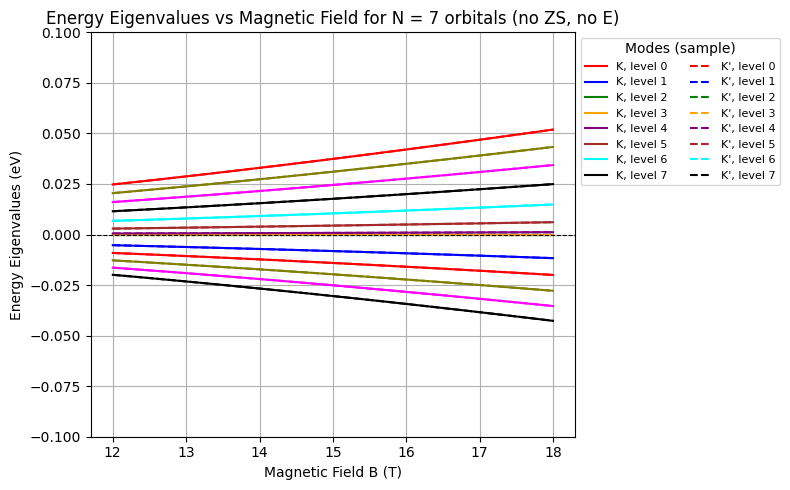

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

# Define a manual list of colors (extend as needed)
color_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'black', 'magenta', 'olive']
num_levels = 4 * N

# Make sure we have enough colors
while len(color_list) < num_levels:
    color_list += color_list  # repeat list if necessary

legend_lines = []
legend_labels = []

# Plot K valley (solid lines)
for level in range(num_levels):
    color = color_list[level]
    line, = ax.plot(B_values, all_eigenvalues_K_var_B[:, level],
                    color=color, linestyle='-')
    if level < 8:
        legend_lines.append(line)
        legend_labels.append(f'K, level {level}')

# Plot K′ valley (dashed lines)
for level in range(num_levels):
    color = color_list[level]  # same color for corresponding level
    line, = ax.plot(B_values, all_eigenvalues_K_prime_var_B[:, level],
                    color=color, linestyle='--')
    if level < 8:
        legend_lines.append(line)
        legend_labels.append(f"K', level {level}")

# Axes and title
ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.1)
ax.set_title(f'Energy Eigenvalues vs Magnetic Field for N = {N} orbitals (no ZS, no E)')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')
ax.grid()

# Legend
ax.legend(handles=legend_lines, labels=legend_labels,
          loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Modes (sample)")

plt.savefig("Energy Eigenvalues vs Magnetic Field (no ZS, no E).pdf", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

## Now introducing ZS

In [10]:
# Arrays to store eigenvalues
all_eigenvalues_ZS_K_var_B_spin_up = np.zeros((len(B_values), 4 * N))
all_eigenvalues_ZS_K_var_B_spin_down = np.zeros((len(B_values), 4 * N))

all_eigenvalues_ZS_K_prime_var_B_spin_up = np.zeros((len(B_values), 4 * N))
all_eigenvalues_ZS_K_prime_var_B_spin_down = np.zeros((len(B_values), 4 * N))

In [11]:
def hamiltonian_matrix_ZS_K_var_B_spin_up(N, delta_ZS, omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    # Identity and zero for N x N blocks
    I = np.eye(N)
    Z = np.zeros((N, N))

    # Precompute operators that will fill the 4x4 blocks
    H11 = delta_ZS * I
    H12 = hbar * omega_B * a
    H13 = - hbar * (sqrt2 * v4 / l_B) * a
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = H12.T
    H22 = (delta_prime + delta_ZS) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a

    H31 = H13.T
    H32 = H23
    H33 = (V_A2 + delta_prime + delta_ZS) * I
    H34 = hbar * omega_B * a

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = H24.T
    H43 = H34.T
    H44 = (V_B2 + delta_ZS) * I

    # Combine into 4N x 4N full Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_K_var_B_spin_up = np.vstack([top, mid1, mid2, bot])
    return H_ZS_K_var_B_spin_up

In [12]:
def hamiltonian_matrix_ZS_K_var_B_spin_down(N, delta_ZS, omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    # Identity and zero for N x N blocks
    I = np.eye(N)
    Z = np.zeros((N, N))

    # Precompute operators that will fill the 4x4 blocks
    H11 = -delta_ZS * I
    H12 = hbar * omega_B * a
    H13 = - hbar * (sqrt2 * v4 / l_B) * a
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = H12.T
    H22 = (delta_prime - delta_ZS) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a

    H31 = H13.T
    H32 = H23
    H33 = (V_A2 + delta_prime - delta_ZS) * I
    H34 = hbar * omega_B * a

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = H24.T
    H43 = H34.T
    H44 = (V_B2 - delta_ZS) * I

    # Combine into 4N x 4N full Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_K_var_B_spin_down = np.vstack([top, mid1, mid2, bot])
    return H_ZS_K_var_B_spin_down

In [13]:
def hamiltonian_matrix_ZS_K_prime_var_B_spin_up(N, delta_ZS ,omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    # Construct 4x4 block matrix pieces (K' valley)
    H11 = delta_ZS * I
    H12 = hbar * omega_B * a_dag         # NOTE: flipped operator compared to K
    H13 = - hbar * (sqrt2 * v4 / l_B) * a_dag
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = hbar * omega_B * a             # flipped again
    H22 = (delta_prime + delta_ZS) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a_dag

    H31 = - hbar * (sqrt2 * v4 / l_B) * a
    H32 = H23
    H33 = (V_A2 + delta_prime + delta_ZS) * I
    H34 = hbar * omega_B * a_dag

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = - hbar * (sqrt2 * v4 / l_B) * a
    H43 = hbar * omega_B * a
    H44 = (V_B2 + delta_ZS) * I

    # Assemble full 4N x 4N Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_K_prime_var_B_spin_up = np.vstack([top, mid1, mid2, bot])
    return H_ZS_K_prime_var_B_spin_up

In [14]:
def hamiltonian_matrix_ZS_K_prime_var_B_spin_down(N, delta_ZS ,omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    # Construct 4x4 block matrix pieces (K' valley)
    H11 = -delta_ZS * I
    H12 = hbar * omega_B * a_dag         # NOTE: flipped operator compared to K
    H13 = - hbar * (sqrt2 * v4 / l_B) * a_dag
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = hbar * omega_B * a             # flipped again
    H22 = (delta_prime - delta_ZS) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a_dag

    H31 = - hbar * (sqrt2 * v4 / l_B) * a
    H32 = H23
    H33 = (V_A2 + delta_prime - delta_ZS) * I
    H34 = hbar * omega_B * a_dag

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = - hbar * (sqrt2 * v4 / l_B) * a
    H43 = hbar * omega_B * a
    H44 = (V_B2 - delta_ZS) * I

    # Assemble full 4N x 4N Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_K_prime_var_B_spin_down = np.vstack([top, mid1, mid2, bot])
    return H_ZS_K_prime_var_B_spin_down

In [15]:
# Compute and store eigenvalues
for i, B in enumerate(B_values):
    omega_B = e * B / m_eff  # or any relation depending on units
    V_A2 = hankel_transform(V_SC, r_A2, B)
    V_B2 = hankel_transform(V_SC, r_B2, B)
    l_B = np.sqrt((hbar * c) / (e * B))
    delta_ZS = g * mu_B * B

    H_ZS_K_var_B_spin_up = hamiltonian_matrix_ZS_K_var_B_spin_up(N, delta_ZS , omega_B, V_A2, V_B2, l_B)
    H_ZS_K_var_B_spin_down = hamiltonian_matrix_ZS_K_var_B_spin_down(N, delta_ZS , omega_B, V_A2, V_B2, l_B)
    
    H_ZS_K_prime_var_B_spin_up = hamiltonian_matrix_ZS_K_prime_var_B_spin_up(N, delta_ZS ,omega_B, V_A2, V_B2, l_B)
    H_ZS_K_prime_var_B_spin_down = hamiltonian_matrix_ZS_K_prime_var_B_spin_down(N, delta_ZS ,omega_B, V_A2, V_B2, l_B)

    eigvals_ZS_K_var_B_spin_up = np.linalg.eigvalsh(H_ZS_K_var_B_spin_up) / e     # Hermitian, more efficient
    eigvals_ZS_K_var_B_spin_down = np.linalg.eigvalsh(H_ZS_K_var_B_spin_down) / e
    
    eigvals_ZS_K_prime_var_B_spin_up = np.linalg.eigvalsh(H_ZS_K_prime_var_B_spin_up) / e
    eigvals_ZS_K_prime_var_B_spin_down = np.linalg.eigvalsh(H_ZS_K_prime_var_B_spin_down) / e

    # Store sorted eigenvalues
    all_eigenvalues_ZS_K_var_B_spin_up[i, :] = np.sort(eigvals_ZS_K_var_B_spin_up)
    all_eigenvalues_ZS_K_var_B_spin_down[i, :] = np.sort(eigvals_ZS_K_var_B_spin_down)
    
    all_eigenvalues_ZS_K_prime_var_B_spin_up[i, :] = np.sort(eigvals_ZS_K_prime_var_B_spin_up)
    all_eigenvalues_ZS_K_prime_var_B_spin_down[i, :] = np.sort(eigvals_ZS_K_prime_var_B_spin_down)

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


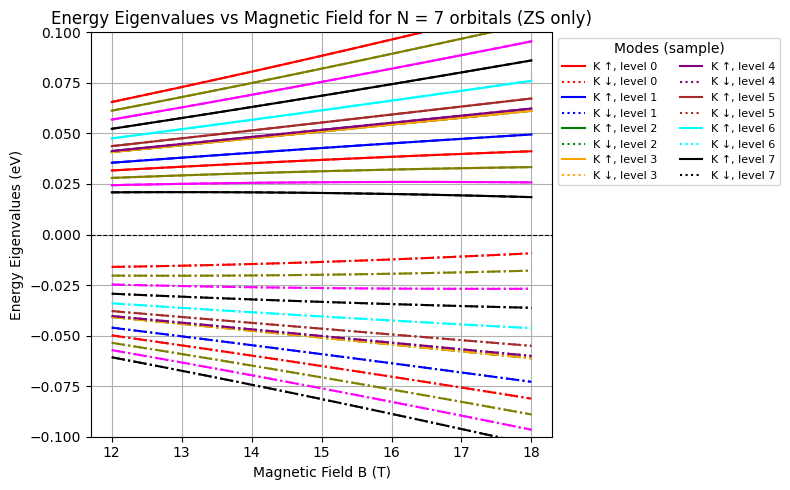

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

# Define manual list of distinguishable colors
color_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'black', 'magenta', 'olive']
num_levels = 4 * N

# Ensure enough colors
while len(color_list) < num_levels:
    color_list += color_list  # repeat if not enough

legend_lines = []
legend_labels = []

for level in range(num_levels):
    color = color_list[level]

    # K valley
    line_up, = ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_up[:, level],
                       color=color, linestyle='-')  # solid for spin up
    line_down, = ax.plot(B_values, all_eigenvalues_ZS_K_var_B_spin_down[:, level],
                         color=color, linestyle=':')  # dotted for spin down

    # K′ valley
    ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_up[:, level],
            color=color, linestyle='--')  # dashed for spin up
    ax.plot(B_values, all_eigenvalues_ZS_K_prime_var_B_spin_down[:, level],
            color=color, linestyle='-.')  # dash-dot for spin down

    # Add to legend only a few levels
    if level < 8:
        legend_lines += [line_up, line_down]
        legend_labels += [f'K ↑, level {level}', f'K ↓, level {level}']

# Axes and labels
ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.1)
ax.set_title(f'Energy Eigenvalues vs Magnetic Field for N = {N} orbitals (ZS only)')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')
ax.grid()

# Legend with sample levels
ax.legend(handles=legend_lines, labels=legend_labels,
          loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Modes (sample)")

plt.tight_layout()
plt.savefig("Energy Eigenvalues vs Magnetic Field (considering ZS only).pdf", dpi=300, bbox_inches="tight")
plt.show()

## Now considering both ZS and Electric field

In [17]:
# Arrays to store eigenvalues
all_eigenvalues_ZS_EF_K_var_B_spin_up = np.zeros((len(B_values), 4 * N))
all_eigenvalues_ZS_EF_K_var_B_spin_down = np.zeros((len(B_values), 4 * N))

all_eigenvalues_ZS_EF_K_prime_var_B_spin_up = np.zeros((len(B_values), 4 * N))
all_eigenvalues_ZS_EF_K_prime_var_B_spin_down = np.zeros((len(B_values), 4 * N))

In [18]:
potential_diff_const = e * E_const * d/2

In [19]:
def hamiltonian_matrix_ZS_EF_K_var_B_spin_up(N, delta_ZS, omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    # Identity and zero for N x N blocks
    I = np.eye(N)
    Z = np.zeros((N, N))

    # Precompute operators that will fill the 4x4 blocks
    H11 = (delta_ZS + potential_diff_const) * I
    H12 = hbar * omega_B * a
    H13 = - hbar * (sqrt2 * v4 / l_B) * a
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = H12.T
    H22 = (delta_prime + delta_ZS + potential_diff_const) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a

    H31 = H13.T
    H32 = H23
    H33 = (V_A2 + delta_prime + delta_ZS - potential_diff_const) * I
    H34 = hbar * omega_B * a

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = H24.T
    H43 = H34.T
    H44 = (V_B2 + delta_ZS - potential_diff_const) * I

    # Combine into 4N x 4N full Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_var_B_spin_up = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_var_B_spin_up

In [20]:
def hamiltonian_matrix_ZS_EF_K_var_B_spin_down(N, delta_ZS, omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    # Identity and zero for N x N blocks
    I = np.eye(N)
    Z = np.zeros((N, N))

    # Precompute operators that will fill the 4x4 blocks
    H11 = (-delta_ZS + potential_diff_const) * I
    H12 = hbar * omega_B * a
    H13 = - hbar * (sqrt2 * v4 / l_B) * a
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = H12.T
    H22 = (delta_prime - delta_ZS + potential_diff_const) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a

    H31 = H13.T
    H32 = H23
    H33 = (V_A2 + delta_prime - delta_ZS - potential_diff_const) * I
    H34 = hbar * omega_B * a

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = H24.T
    H43 = H34.T
    H44 = (V_B2 - delta_ZS - potential_diff_const) * I

    # Combine into 4N x 4N full Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_var_B_spin_down = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_var_B_spin_down

In [21]:
def hamiltonian_matrix_ZS_EF_K_prime_var_B_spin_up(N, delta_ZS ,omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    # Construct 4x4 block matrix pieces (K' valley)
    H11 = (delta_ZS + potential_diff_const) * I
    H12 = hbar * omega_B * a_dag         # NOTE: flipped operator compared to K
    H13 = - hbar * (sqrt2 * v4 / l_B) * a_dag
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = hbar * omega_B * a             # flipped again
    H22 = (delta_prime + delta_ZS + potential_diff_const) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a_dag

    H31 = - hbar * (sqrt2 * v4 / l_B) * a
    H32 = H23
    H33 = (V_A2 + delta_prime + delta_ZS - potential_diff_const) * I
    H34 = hbar * omega_B * a_dag

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = - hbar * (sqrt2 * v4 / l_B) * a
    H43 = hbar * omega_B * a
    H44 = (V_B2 + delta_ZS - potential_diff_const) * I

    # Assemble full 4N x 4N Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_prime_var_B_spin_up = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_prime_var_B_spin_up

In [22]:
def hamiltonian_matrix_ZS_EF_K_prime_var_B_spin_down(N, delta_ZS ,omega_B, V_A2, V_B2, l_B):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    # Construct 4x4 block matrix pieces (K' valley)
    H11 = (-delta_ZS + potential_diff_const) * I
    H12 = hbar * omega_B * a_dag         # NOTE: flipped operator compared to K
    H13 = - hbar * (sqrt2 * v4 / l_B) * a_dag
    H14 = hbar * (sqrt2 * v3 / l_B) * a_dag

    H21 = hbar * omega_B * a             # flipped again
    H22 = (delta_prime - delta_ZS + potential_diff_const) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B) * a_dag

    H31 = - hbar * (sqrt2 * v4 / l_B) * a
    H32 = H23
    H33 = (V_A2 + delta_prime - delta_ZS - potential_diff_const) * I
    H34 = hbar * omega_B * a_dag

    H41 = hbar * (sqrt2 * v3 / l_B) * a
    H42 = - hbar * (sqrt2 * v4 / l_B) * a
    H43 = hbar * omega_B * a
    H44 = (V_B2 - delta_ZS - potential_diff_const) * I

    # Assemble full 4N x 4N Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_prime_var_B_spin_down = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_prime_var_B_spin_down

In [23]:
# Compute and store eigenvalues
for i, B in enumerate(B_values):
    omega_B = e * B / m_eff  # or any relation depending on units
    V_A2 = hankel_transform(V_SC, r_A2, B)
    V_B2 = hankel_transform(V_SC, r_B2, B)
    l_B = np.sqrt((hbar * c) / (e * B))
    delta_ZS = g * mu_B * B

    H_ZS_EF_K_var_B_spin_up = hamiltonian_matrix_ZS_EF_K_var_B_spin_up(N, delta_ZS , omega_B, V_A2, V_B2, l_B)
    H_ZS_EF_K_var_B_spin_down = hamiltonian_matrix_ZS_EF_K_var_B_spin_down(N, delta_ZS , omega_B, V_A2, V_B2, l_B)
    
    H_ZS_EF_K_prime_var_B_spin_up = hamiltonian_matrix_ZS_EF_K_prime_var_B_spin_up(N, delta_ZS ,omega_B, V_A2, V_B2, l_B)
    H_ZS_EF_K_prime_var_B_spin_down = hamiltonian_matrix_ZS_EF_K_prime_var_B_spin_down(N, delta_ZS ,omega_B, V_A2, V_B2, l_B)

    eigvals_ZS_EF_K_var_B_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_var_B_spin_up) / e     # Hermitian, more efficient
    eigvals_ZS_EF_K_var_B_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_var_B_spin_down) / e
    
    eigvals_ZS_EF_K_prime_var_B_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_B_spin_up) / e
    eigvals_ZS_EF_K_prime_var_B_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_B_spin_down) / e

    # Store sorted eigenvalues
    all_eigenvalues_ZS_EF_K_var_B_spin_up[i, :] = np.sort(eigvals_ZS_EF_K_var_B_spin_up)
    all_eigenvalues_ZS_EF_K_var_B_spin_down[i, :] = np.sort(eigvals_ZS_EF_K_var_B_spin_down)
    
    all_eigenvalues_ZS_EF_K_prime_var_B_spin_up[i, :] = np.sort(eigvals_ZS_EF_K_prime_var_B_spin_up)
    all_eigenvalues_ZS_EF_K_prime_var_B_spin_down[i, :] = np.sort(eigvals_ZS_EF_K_prime_var_B_spin_down)

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


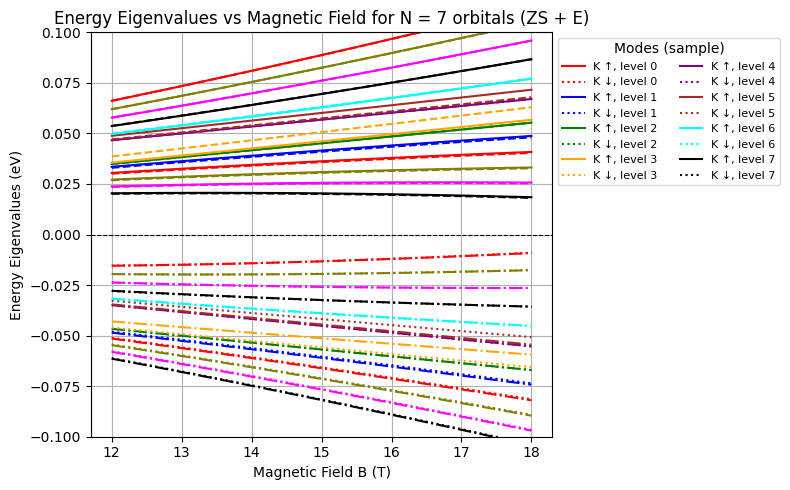

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

# Define a manual list of visually distinct colors
color_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'black', 'magenta', 'olive']
num_levels = 4 * N

# Ensure enough colors
while len(color_list) < num_levels:
    color_list += color_list  # Repeat to fill up if needed

legend_lines = []
legend_labels = []

for level in range(num_levels):
    color = color_list[level]

    # K valley
    line_up, = ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_up[:, level],
                       color=color, linestyle='-')  # solid for spin up
    line_down, = ax.plot(B_values, all_eigenvalues_ZS_EF_K_var_B_spin_down[:, level],
                         color=color, linestyle=':')  # dotted for spin down

    # K′ valley
    ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_up[:, level],
            color=color, linestyle='--')  # dashed for spin up
    ax.plot(B_values, all_eigenvalues_ZS_EF_K_prime_var_B_spin_down[:, level],
            color=color, linestyle='-.')  # dash-dot for spin down

    # Add to legend only a few levels
    if level < 8:
        legend_lines += [line_up, line_down]
        legend_labels += [f'K ↑, level {level}', f'K ↓, level {level}']

# Labels and formatting
ax.set_xlabel('Magnetic Field B (T)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.1, 0.1)
ax.set_title(f'Energy Eigenvalues vs Magnetic Field for N = {N} orbitals (ZS + E)')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Zero energy reference
ax.grid()

# Add legend for sample levels
ax.legend(handles=legend_lines, labels=legend_labels,
          loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Modes (sample)")

plt.tight_layout()
plt.savefig("Energy Eigenvalues vs Magnetic Field (ZS + E).pdf", dpi=300, bbox_inches="tight")
plt.show()

## Energy Eigenvalues vs Potential Difference

In [25]:
potential_diff_const / e    ## eV

0.0058625000000000005

In [26]:
U_values = np.linspace(0 * e, 0.1 * e, 100)  ## not in eV

In [27]:
# Arrays to store eigenvalues
all_eigenvalues_ZS_EF_K_var_E_spin_up = np.zeros((len(B_values), 4 * N))
all_eigenvalues_ZS_EF_K_var_E_spin_down = np.zeros((len(B_values), 4 * N))

all_eigenvalues_ZS_EF_K_prime_var_E_spin_up = np.zeros((len(B_values), 4 * N))
all_eigenvalues_ZS_EF_K_prime_var_E_spin_down = np.zeros((len(B_values), 4 * N))

In [28]:
omega_B_const = e * B_const / m_eff  # or any relation depending on units
V_A2_const = hankel_transform(V_SC, r_A2, B_const)
V_B2_const = hankel_transform(V_SC, r_B2, B_const)
l_B_const = np.sqrt((hbar * c) / (e * B_const))
delta_ZS_const = g * mu_B * B_const

<ipython-input-3-95687ab231f9>:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = integrate.quad(integrand, 0, np.inf, limit=100)


In [29]:
def hamiltonian_matrix_ZS_EF_K_var_E_spin_up(N, U):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    # Identity and zero for N x N blocks
    I = np.eye(N)
    Z = np.zeros((N, N))

    # Precompute operators that will fill the 4x4 blocks
    H11 = (delta_ZS_const + U) * I
    H12 = hbar * omega_B_const * a
    H13 = - hbar * (sqrt2 * v4 / l_B_const) * a
    H14 = hbar * (sqrt2 * v3 / l_B_const) * a_dag

    H21 = H12.T
    H22 = (delta_prime + delta_ZS_const + U) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B_const) * a

    H31 = H13.T
    H32 = H23
    H33 = (V_A2_const + delta_prime + delta_ZS_const - U) * I
    H34 = hbar * omega_B_const * a

    H41 = hbar * (sqrt2 * v3 / l_B_const) * a
    H42 = H24.T
    H43 = H34.T
    H44 = (V_B2_const + delta_ZS_const - U) * I

    # Combine into 4N x 4N full Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_var_E_spin_up = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_var_E_spin_up

In [30]:
def hamiltonian_matrix_ZS_EF_K_var_E_spin_down(N, U):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    # Identity and zero for N x N blocks
    I = np.eye(N)
    Z = np.zeros((N, N))

    # Precompute operators that will fill the 4x4 blocks
    H11 = (-delta_ZS_const + U) * I
    H12 = hbar * omega_B_const * a
    H13 = - hbar * (sqrt2 * v4 / l_B_const) * a
    H14 = hbar * (sqrt2 * v3 / l_B_const) * a_dag

    H21 = H12.T
    H22 = (delta_prime - delta_ZS_const + U) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B_const) * a

    H31 = H13.T
    H32 = H23
    H33 = (V_A2_const + delta_prime - delta_ZS_const - U) * I
    H34 = hbar * omega_B_const * a

    H41 = hbar * (sqrt2 * v3 / l_B_const) * a
    H42 = H24.T
    H43 = H34.T
    H44 = (V_B2_const - delta_ZS_const - U) * I

    # Combine into 4N x 4N full Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_var_E_spin_down = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_var_E_spin_down

In [31]:
def hamiltonian_matrix_ZS_EF_K_prime_var_E_spin_up(N, U):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    # Construct 4x4 block matrix pieces (K' valley)
    H11 = (delta_ZS_const + U) * I
    H12 = hbar * omega_B_const * a_dag         # NOTE: flipped operator compared to K
    H13 = - hbar * (sqrt2 * v4 / l_B_const) * a_dag
    H14 = hbar * (sqrt2 * v3 / l_B_const) * a_dag

    H21 = hbar * omega_B_const * a             # flipped again
    H22 = (delta_prime + delta_ZS_const + U) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B_const) * a_dag

    H31 = - hbar * (sqrt2 * v4 / l_B_const) * a
    H32 = H23
    H33 = (V_A2_const + delta_prime + delta_ZS_const - U) * I
    H34 = hbar * omega_B_const * a_dag

    H41 = hbar * (sqrt2 * v3 / l_B_const) * a
    H42 = - hbar * (sqrt2 * v4 / l_B_const) * a
    H43 = hbar * omega_B_const * a
    H44 = (V_B2_const + delta_ZS_const - U) * I

    # Assemble full 4N x 4N Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_prime_var_E_spin_up = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_prime_var_E_spin_up

In [32]:
def hamiltonian_matrix_ZS_EF_K_prime_var_E_spin_down(N, U):
    a, a_dag = create_annihilation_operators(N)
    sqrt2 = np.sqrt(2)

    I = np.eye(N)
    Z = np.zeros((N, N))

    # Construct 4x4 block matrix pieces (K' valley)
    H11 = (-delta_ZS_const + U) * I
    H12 = hbar * omega_B_const * a_dag         # NOTE: flipped operator compared to K
    H13 = - hbar * (sqrt2 * v4 / l_B_const) * a_dag
    H14 = hbar * (sqrt2 * v3 / l_B_const) * a_dag

    H21 = hbar * omega_B_const * a             # flipped again
    H22 = (delta_prime - delta_ZS_const + U) * I
    H23 = gamma_1 * I
    H24 = - hbar * (sqrt2 * v4 / l_B_const) * a_dag

    H31 = - hbar * (sqrt2 * v4 / l_B_const) * a
    H32 = H23
    H33 = (V_A2_const + delta_prime - delta_ZS_const - U) * I
    H34 = hbar * omega_B_const * a_dag

    H41 = hbar * (sqrt2 * v3 / l_B_const) * a
    H42 = - hbar * (sqrt2 * v4 / l_B_const) * a
    H43 = hbar * omega_B_const * a
    H44 = (V_B2_const - delta_ZS_const - U) * I

    # Assemble full 4N x 4N Hamiltonian
    top = np.hstack([H11, H12, H13, H14])
    mid1 = np.hstack([H21, H22, H23, H24])
    mid2 = np.hstack([H31, H32, H33, H34])
    bot = np.hstack([H41, H42, H43, H44])

    H_ZS_EF_K_prime_var_E_spin_down = np.vstack([top, mid1, mid2, bot])
    return H_ZS_EF_K_prime_var_E_spin_down

In [33]:
# Compute and store eigenvalues
for i, U in enumerate(U_values):

    H_ZS_EF_K_var_E_spin_up = hamiltonian_matrix_ZS_EF_K_var_E_spin_up(N, U)
    H_ZS_EF_K_var_E_spin_down = hamiltonian_matrix_ZS_EF_K_var_E_spin_down(N, U)
    
    H_ZS_EF_K_prime_var_E_spin_up = hamiltonian_matrix_ZS_EF_K_prime_var_E_spin_up(N, U)
    H_ZS_EF_K_prime_var_E_spin_down = hamiltonian_matrix_ZS_EF_K_prime_var_E_spin_down(N, U)

    eigvals_ZS_EF_K_var_E_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_var_E_spin_up) / e     # Hermitian, more efficient
    eigvals_ZS_EF_K_var_E_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_var_E_spin_down) / e
    
    eigvals_ZS_EF_K_prime_var_E_spin_up = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_E_spin_up) / e
    eigvals_ZS_EF_K_prime_var_E_spin_down = np.linalg.eigvalsh(H_ZS_EF_K_prime_var_E_spin_down) / e

    # Store sorted eigenvalues
    all_eigenvalues_ZS_EF_K_var_E_spin_up[i, :] = np.sort(eigvals_ZS_EF_K_var_E_spin_up)
    all_eigenvalues_ZS_EF_K_var_E_spin_down[i, :] = np.sort(eigvals_ZS_EF_K_var_E_spin_down)
    
    all_eigenvalues_ZS_EF_K_prime_var_E_spin_up[i, :] = np.sort(eigvals_ZS_EF_K_prime_var_E_spin_up)
    all_eigenvalues_ZS_EF_K_prime_var_E_spin_down[i, :] = np.sort(eigvals_ZS_EF_K_prime_var_E_spin_down)

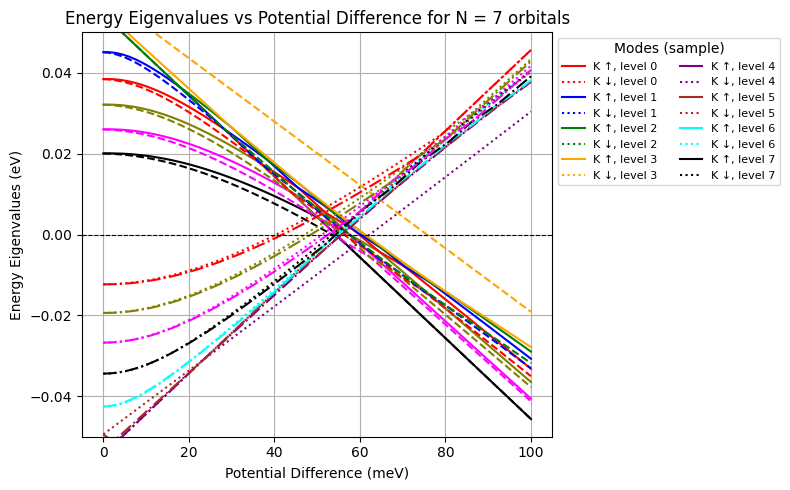

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

# Define manual color list
color_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'black', 'magenta', 'olive']
num_levels = 4 * N

# Repeat colors if needed
while len(color_list) < num_levels:
    color_list += color_list

legend_lines = []
legend_labels = []

# X-axis in meV
U_vals_meV = U_values * 1e3 / e

for level in range(num_levels):
    color = color_list[level]

    # K valley
    line_up, = ax.plot(U_vals_meV, all_eigenvalues_ZS_EF_K_var_E_spin_up[:, level],
                       color=color, linestyle='-')  # solid for spin up
    line_down, = ax.plot(U_vals_meV, all_eigenvalues_ZS_EF_K_var_E_spin_down[:, level],
                         color=color, linestyle=':')  # dotted for spin down

    # K′ valley
    ax.plot(U_vals_meV, all_eigenvalues_ZS_EF_K_prime_var_E_spin_up[:, level],
            color=color, linestyle='--')  # dashed for spin up
    ax.plot(U_vals_meV, all_eigenvalues_ZS_EF_K_prime_var_E_spin_down[:, level],
            color=color, linestyle='-.')  # dash-dot for spin down

    # Add to legend only a few sample levels
    if level < 8:
        legend_lines += [line_up, line_down]
        legend_labels += [f'K ↑, level {level}', f'K ↓, level {level}']

# Labels and formatting
ax.set_xlabel('Potential Difference (meV)')
ax.set_ylabel('Energy Eigenvalues (eV)')
ax.set_ylim(-0.05, 0.05)
ax.set_title(f'Energy Eigenvalues vs Potential Difference for N = {N} orbitals')
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')  # Zero energy reference
ax.grid()

# Legend for sample levels
ax.legend(handles=legend_lines, labels=legend_labels,
          loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8, title="Modes (sample)")

plt.tight_layout()
plt.savefig("Energy Eigenvalues vs Potential Difference.pdf", dpi=300, bbox_inches="tight")
plt.show()